In [1]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm

import requests
import io

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
df_data = pd.read_csv(url, error_bad_lines=False)

In [3]:
countries = ['China', 'Italy','Spain']
th = 2

data= {}
for country in countries:
    value = df_data[df_data['Country/Region']== country].drop(['Province/State','Country/Region','Lat','Long'], axis=1).sum(axis=0)
    value = value[value >= th] 
    data[country+'-death'] = value.values
    days = len(data[country+'-death'])
    data[country+'-day'] = np.linspace(0,days-1,days)
    data[country+'-date'] = value.index.values
    

In [4]:
Dates = {'Spain':{'3/8/20':['M8','-.'],'3/13/20':['Lockdown','--']},
'Italy':{'3/9/20':['Lockdown','--']},
'Hubai':{'1/23/20':['Lockdown','--']}}

In [146]:
n_countries = len(countries)

#hide
with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    clim = {}
    
    clim['c1s'] = 0.4
    clim['c1M'] = 0.4
    
    clim['c2s'] = 25
    clim['c2M'] = 25
    
    clim['c3s'] = 3500
    clim['c3M'] = 5000
    
    const = {}
    for cn in ['c1','c2','c3']:
        grp = pm.Normal(cn+'grp', clim[cn+'M'], clim[cn+'s'])
        # Group variance
        grp_sigma = pm.HalfNormal(cn+'grp_sigma', clim[cn+'s'])
        # Individual intercepts
        const[cn] = pm.Normal(cn,  mu=grp, sigma=grp_sigma,  shape=n_countries)
    
    # Error
    sigma = pm.HalfNormal('sigma', 500., shape=n_countries)
    
    # Create likelihood for each country
    for i, country in enumerate(countries):
        print(country)
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(country + "-x",  data[country+'-day'])
        cases = pm.Data(country + "-y",  data[country+'-death'])
        
        # Likelihood
        pm.NegativeBinomial(
            country, 
            const['c3'][i]*(1/(1 + np.exp(-(const['c1'][i] * (-const['c2'][i] + x))))),
            sigma[i], 
            observed=cases)
        

    

China
Italy
Spain


In [149]:
#hide
with model:
    # Sample posterior
    trace = pm.sample(tune=3000, chains=1, cores=1, target_accept=.9)
    
    # Update data so that we get predictions into the future
    for country in countries:
        x_data = np.arange(0, 60)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({country + "-x": x_data})
        pm.set_data({country + "-y": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=100)

Auto-assigning NUTS sampler...
I0316 13:34:01.001380 4361332160 sampling.py:414] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
I0316 13:34:01.006437 4361332160 sampling.py:1581] Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
I0316 13:34:11.537926 4361332160 sampling.py:487] Sequential sampling (1 chains in 1 job)
NUTS: [sigma, c3, c3grp_sigma, c3grp, c2, c2grp_sigma, c2grp, c1, c1grp_sigma, c1grp]
I0316 13:34:11.540569 4361332160 sampling.py:206] NUTS: [sigma, c3, c3grp_sigma, c3grp, c2, c2grp_sigma, c2grp, c1, c1grp_sigma, c1grp]
Sampling chain 0, 39 divergences: 100%|██████████| 3500/3500 [03:38<00:00, 13.13it/s]
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
E0316 13:37:50.534867 4361332160 report.py:143] There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8202859930642604, but should be

In [110]:
def res_values(values, flag_res):
    res = values
    if flag_res:
        values_dif = np.roll(values, -1) - np.roll(values, 1)
        res = np.roll(values_dif, 0)/np.roll(values_dif, 1)
    return res

def func_sig(X, *p, flag_res):
    if flag_res:
        c1,c2,c3 = p
        AB = np.exp(c1*c2)
        A = np.exp(c1)
        AX = np.exp(c1*X)
        model = (A*AB+AX) / (AB + A*AX)
    else:
        c1,c2,c3 = p
        model = c3*(1/(1 + np.exp(-(c1 * (-c2 + X)))))
    return model

def plot_results(param):
    data = param['data']
    post_pred = param['post_pred']
    countries = param['countries']
    ylabel = param['ylabel']
    flag_res = param['flag_res']
    xlim = param['xlim']
    ylim = param['ylim'] 
    log_flag = param['log_flag']
    figsize = param['figsize']

    n_countries = len(countries)
    plt.figure(figsize=figsize)
    colors = plt.cm.rainbow(np.linspace(0, 1, n_countries))

    for i, country in enumerate(countries):
        if flag_res:
            plt.subplot(n_countries,1,i+1)
        delay = np.argmin(np.abs(data[country+'-death'] - 17))
        #delay = 0
        plt.scatter(data[country+'-day'] - delay, res_values(data[country+'-death'], flag_res), color=colors[i], label = country+' cumulative Deaths')
        plt.plot(np.arange(0, post_pred[country].shape[1]) - delay, res_values(post_pred[country], flag_res).T, alpha=0.1, color=colors[i])
        p = [np.max(trace['c1'][:,i]),np.max(trace['c2'][:,i]),np.max(trace['c3'][:,i])]
        plt.plot(np.linspace(0,60-1,60) - delay, func_sig(np.linspace(0,60-1,60), *p, flag_res = flag_res), alpha=1, color=colors[i])

        plt.xlabel('# Days from 17 deaths')
        plt.ylabel(ylabel)
        cn = country
        
        if country == 'China':
            cn = 'Hubai'

        for key, value in Dates[cn].items():
            ind = np.argwhere(data[country+'-date'] == key)[0][0]
            plt.plot([ind,ind],[0,15000], value[1], label = cn+'-'+ value[0], color=colors[i])

        plt.ylim(ylim)
        plt.xlim(xlim)

    plt.grid(alpha=0.2)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    if log_flag: 
        plt.yscale('log')

In [115]:
GrowthR = {}
GrowthR['data'] = data
GrowthR['post_pred'] = post_pred
GrowthR['countries'] = countries
GrowthR['ylabel'] = 'Growth factor'
GrowthR['flag_res'] = True
GrowthR['xlim'] = [0,40]
GrowthR['ylim'] = [0,5]
GrowthR['log_flag'] = False
GrowthR['figsize'] = (17, 26)

Sigmoid = {}
Sigmoid['data'] = data
Sigmoid['post_pred'] = post_pred
Sigmoid['countries'] = countries
Sigmoid['ylabel'] = 'Total-deaths'
Sigmoid['flag_res'] = False
Sigmoid['xlim'] = [0,40]
Sigmoid['ylim'] = [0,10000]
Sigmoid['log_flag'] = False
Sigmoid['figsize'] = (17, 7)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.style.use('dark_background')

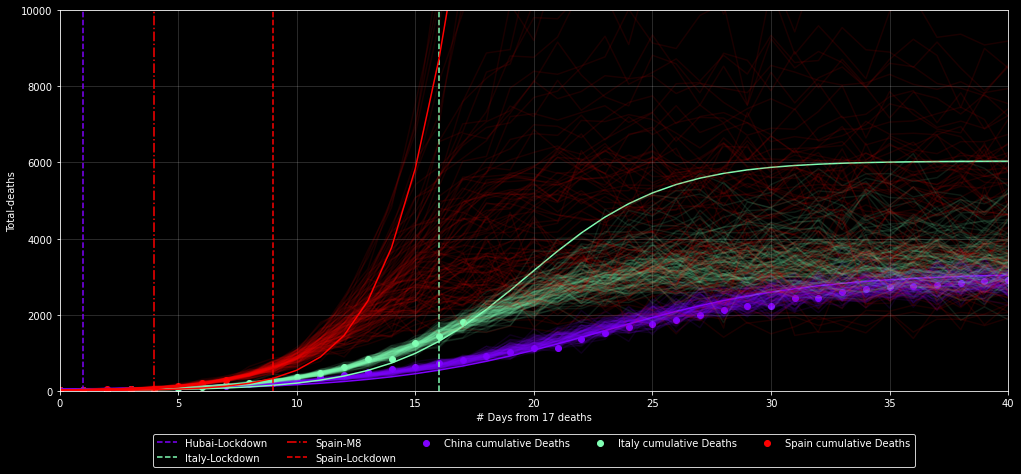

In [116]:
plot_results(Sigmoid)

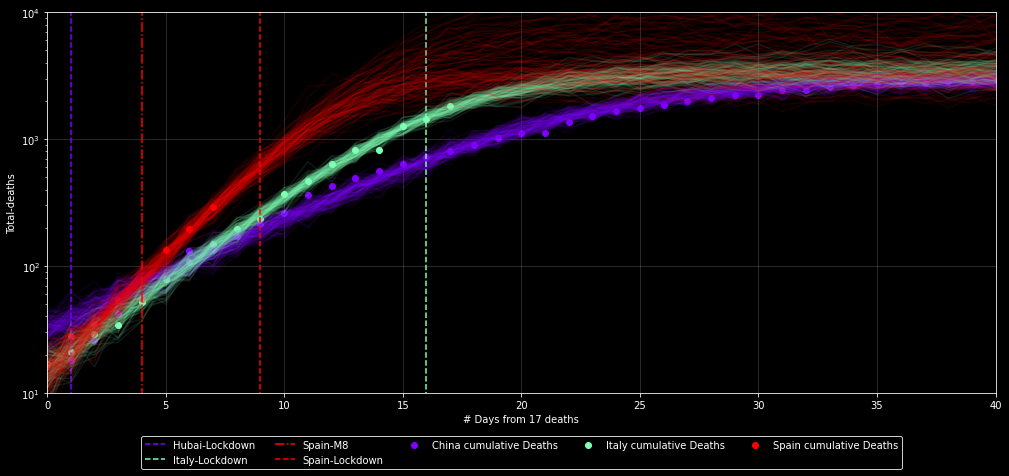

In [53]:
Sigmoid['ylim'] = [10,10000]
Sigmoid['log_flag'] = True
plot_results(Sigmoid)

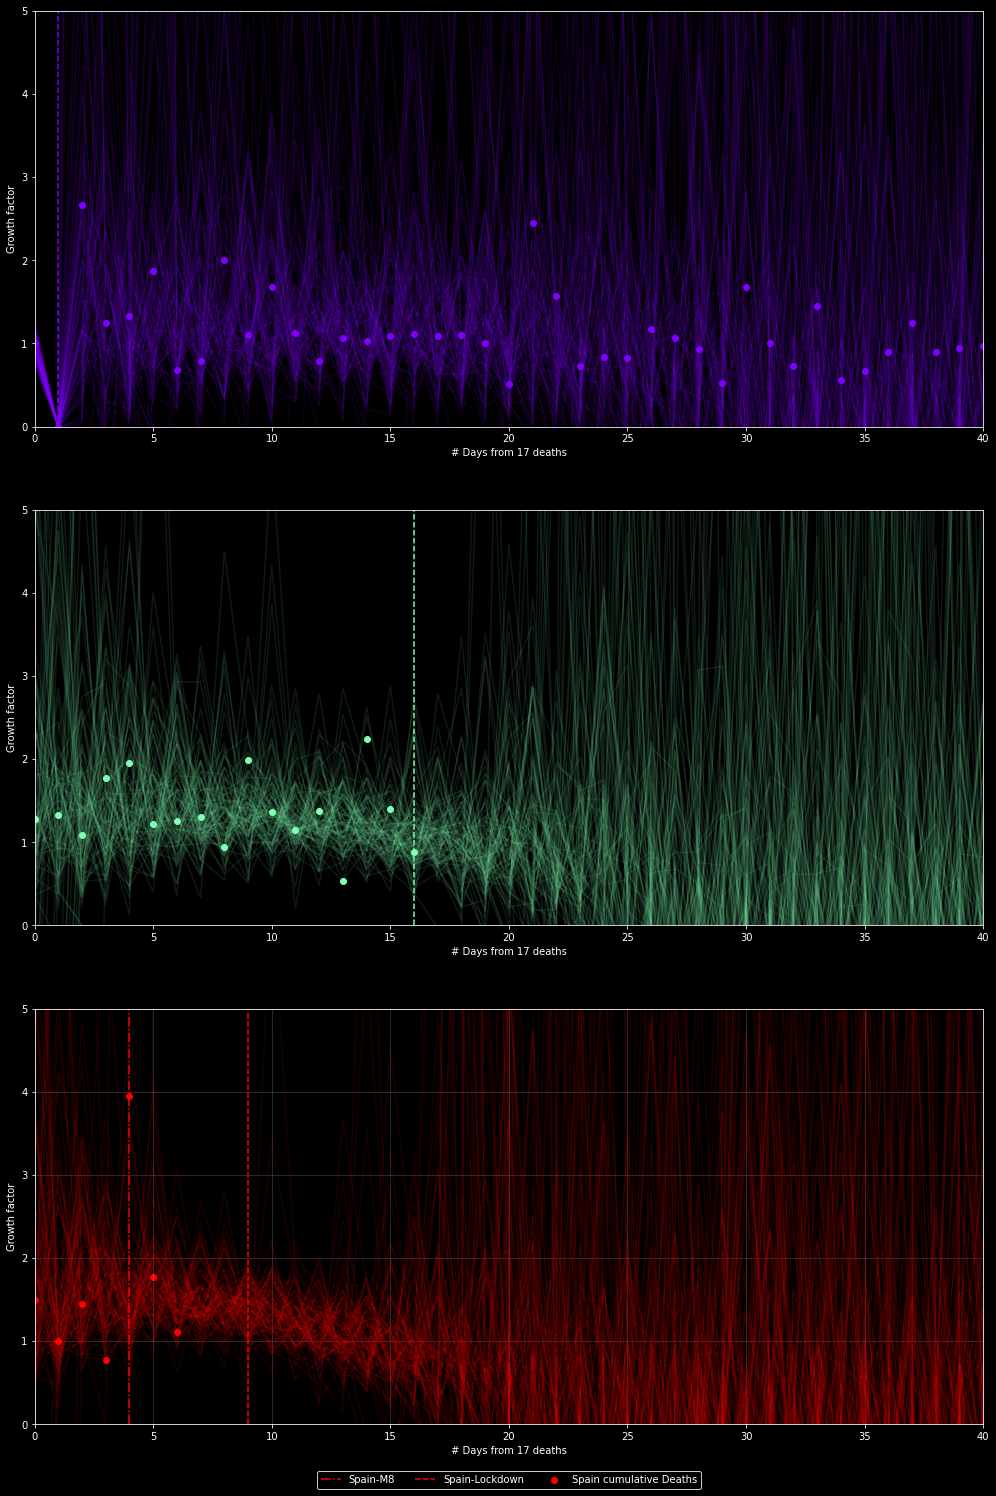

In [54]:
plot_results(GrowthR)

In [258]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['color'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        #if k_is_color:
        color=k_is_color[name]
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        print(color)
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            #color='1',
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            #color='1',            
            vertical=True
        )
        
    plt.legend(legends)

[0.5 0.  1.  1. ]
[0.50392157 0.99998103 0.70492555 1.        ]
[1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]
[0.5 0.  1.  1. ]
[0.50392157 0.99998103 0.70492555 1.        ]
[1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]
[0.5 0.  1.  1. ]
[0.50392157 0.99998103 0.70492555 1.        ]
[1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]


<Figure size 1296x504 with 0 Axes>

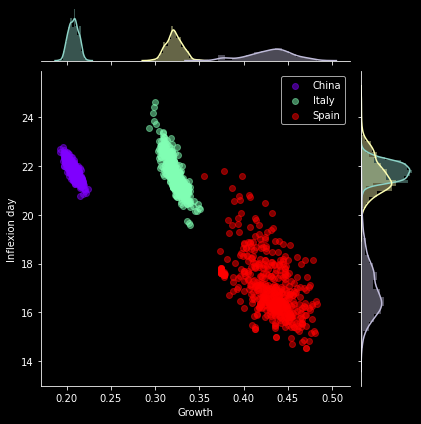

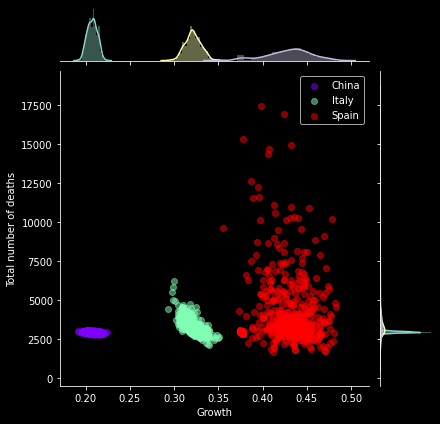

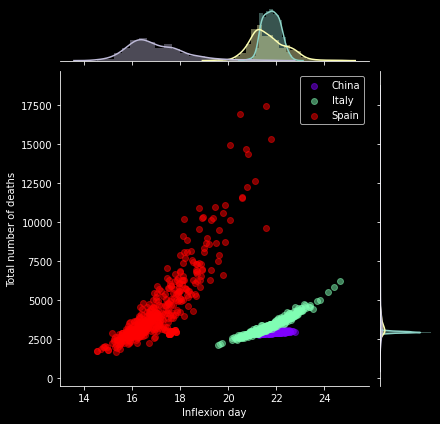

In [259]:
#hide_input
plt.figure(figsize=(18,7))
clabel = {'c1':'Growth','c2':'Inflexion day','c3':'Total number of deaths'}

colors = plt.cm.rainbow(np.linspace(0, 1, len(countries)))
colors_dic = {}                        
for i in range(0, len(countries)):
    colors_dic[countries[i]] = colors[i]
for k, cn in enumerate([['c1','c2'],['c1','c3'],['c2','c3']]):
    df1 = pd.DataFrame(np.append(trace[cn[0]][:, 0],trace[cn[1]][:, 0]).reshape(2,-1).T, columns=[clabel[cn[0]],clabel[cn[1]]])
    df2 = pd.DataFrame(np.append(trace[cn[0]][:, 1],trace[cn[1]][:, 1]).reshape(2,-1).T, columns=[clabel[cn[0]],clabel[cn[1]]])
    df3 = pd.DataFrame(np.append(trace[cn[0]][:, 2],trace[cn[1]][:, 2]).reshape(2,-1).T, columns=[clabel[cn[0]],clabel[cn[1]]])
    df1['country'] = countries[0]
    df2['country'] = countries[1]
    df3['country'] = countries[2]
    df=pd.concat([df1,df2,df3])
    multivariateGrid(clabel[cn[0]],clabel[cn[1]], 'country', df=df, k_is_color = colors_dic)


3